In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt

Gather orange cone masks from each labeled file and append them to one big matrix. Plot this matrix on a scatter plot

In [36]:
folder = 'Data/Labeled'
cone_roi_pixels = np.loadtxt(os.path.join(folder, os.listdir(folder)[0]))
for index in range(1, len(os.listdir(folder))):
    pixels_to_concat = np.loadtxt(os.path.join(folder, os.listdir(folder)[index]))
    cone_roi_pixels = np.concatenate((cone_roi_pixels, pixels_to_concat))

print(np.shape(cone_roi_pixels))

(113961, 3)


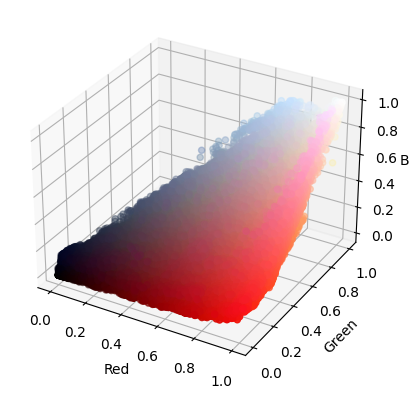

In [46]:
# Plot region of interest points onto scatter plot
fig = plt.figure()
scatter_plot = fig.add_subplot(projection='3d')
red_axis = cone_roi_pixels[:, 0]
green_axis = cone_roi_pixels[:, 1]
blue_axis = cone_roi_pixels[:, 2]
scatter_plot.scatter(red_axis, green_axis, blue_axis, c=cone_roi_pixels)
scatter_plot.set_xlabel('Red')
scatter_plot.set_ylabel('Green')
scatter_plot.set_zlabel('Blue')
plt.show()

Once you have that you want to calculate the mean and standard deviation of this region of interest which will be plugged into Gaussian Distribution. By doing so will get the probability of the orange cone

In [48]:
orange_cone_rgb_mean = cone_roi_pixels.mean(0)
print(orange_cone_rgb_mean)

orange_cone_rgb_variance = cone_roi_pixels.var(0)
print(orange_cone_rgb_variance)

orange_cone_rgb_std = cone_roi_pixels.std(0)
print(orange_cone_rgb_std)

[0.70281537 0.22751554 0.18501084]
[0.06714857 0.0288228  0.02943969]
[0.25913041 0.16977279 0.17157998]
